<a href="https://colab.research.google.com/github/catarina-moreira/causabilityXAi/blob/master/Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demystifying Predictive Black-Box Models: An Interpretable Probabilistic Approach

Catarina Moreira, Yu-Liang Chou, Mythreyi Velmurugan, Renuka Sindhgatta Rajan, Chun Ouyang, Peter Bruza

**Abstract** 


In [1]:
# Install tensorflow
try:
    # tensorflow_version only exists in Colab
    %tensorflow_version 2.x
except Exception:
    pass

In [2]:
# library to deal with Bayesian Networks
!pip install pyagrum

In [68]:
import lime
from lime import lime_tabular


In [3]:
# for reproduciability reasons:
import numpy as np
import pandas as pd
import random as rn
import tensorflow as tf
import csv

%matplotlib inline

# necessary for starting Numpy generated random numbers in an initial state
np.random.seed(515)

# Necessary for starting core Python generated random numbers in a state
rn.seed(515)

# Force TensorFlow to single thread
# Multiple threads are a potential source of non-reprocible research resulsts
session_conf = tf.compat.v1.ConfigProto( intra_op_parallelism_threads=1,
                                          inter_op_parallelism_threads=1 )

# tf.set_random_seed() will make random number generation in the TensorFlow backend
# have a well defined initial state
# more details: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.compat.v1.set_random_seed(515)

# import auxiliary functions
from learning import *

# Bayesian networks
from sklearn.preprocessing import KBinsDiscretizer
from pylab import *
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

# for classification purposes
from pyAgrum.lib.bn2roc import showROC

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import pylab as pl
from pylab import savefig
plt.style.use('seaborn-deep')

In [4]:
# use only if opening on google colab
#from google.colab import drive
#drive.mount('/content/drive')

## Diabetes Dataset

**Context**
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

**Content**
The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the 
- number of pregnancies the patient has had, 
- their BMI, 
- insulin level, 
- age,
- glucose,
- blood pressure,
- skin thickness,
- Diabetes pedigree function


### Checking Dataset

In [5]:
# path to project folder
# please change to your own
PATH = "/Users/catarina/GitHub/causabilityXAi/"

In [6]:
# name of dataset
DATASET_NAME = "diabetes.csv"

# variable containing the class labels in this case the dataset contains:
# 0 - if not diabetes
# 1 - if diabetes
class_var = "Outcome"

# load dataset
dataset_path = PATH + "datasets/" + DATASET_NAME
data = pd.read_csv( dataset_path )

In [72]:
# features
feature_names = data.drop([class_var], axis=1).columns.to_list()

# check how balanced the classes are
data.groupby(class_var).count()

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,500,500,500,500,500,500,500,500
1,268,268,268,268,268,268,268,268


### Balanced Dataset

In [8]:
# balance dataset
sampled_data = data.sample(frac=1)
sampled_data = sampled_data[ sampled_data["Outcome"] == 0]
no_data = sampled_data.sample(frac=1)[0:268]

yes_data = data[ data["Outcome"] == 1]

balanced_data = [no_data,yes_data]
balanced_data = pd.concat(balanced_data)

# check how balanced the classes are
balanced_data.groupby(class_var).count()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,268,268,268,268,268,268,268,268
1,268,268,268,268,268,268,268,268


#### Train a Model for the Balanced Dataset

In [9]:
# apply one hot encoder to data
# standardize the input between 0 and 1
X, Y, encoder, scaler = encode_data( balanced_data, class_var)

n_features = X.shape[1]
n_classes = len(balanced_data[class_var].unique())
 
flag = False  # DO NOT CHANGE! Data has already been generated. 
if flag:
    # save training, test and validation data
    generate_save_training_data( dataset_path, X, Y)
    
else:
    # load existing training data
    X_train, Y_train, X_test, Y_test, X_validation, Y_validation= load_training_data( dataset_path )
    

In [10]:
# generate models for grid search
if flag:
    models = grid_search_model_generator( n_features, n_classes )

    # perform grid_search
    HISTORY_DICT = perform_grid_search( models, PATH, DATASET_NAME.replace(".csv",""), 
                                   X_train, Y_train, 
                                   X_validation, Y_validation, X_test, Y_test, 
                                   batch_size=8, epochs=150 )

In [13]:
path_serialisation_model = PATH + "training/" + DATASET_NAME.replace(".csv", "") + "/model/" 
path_serialisation_histr = PATH + "training/" + DATASET_NAME.replace(".csv", "") + "/history/" 

# the best performing model was obtained with 5 hidden layers with 12 neurons each
model_name = "model_h5_N12"
    
if flag:
    
    # get respective model training history and model
    model_history = HISTORY_DICT[ model_name ][0]
    model = HISTORY_DICT[ model_name ][1]

    # save model and model history to file
    save_model_history(  model_history, model_name, path_serialisation_histr )
    save_model( model, model_name, path_serialisation_model )
else:
    model_history = load_model_history( model_name, path_serialisation_histr )
    model = load_model( model_name, path_serialisation_model )
    
model.summary()

Loaded model from disk
Model: "model_h5_N12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_293 (Dense)            (None, 12)                108       
_________________________________________________________________
dense_294 (Dense)            (None, 12)                156       
_________________________________________________________________
dense_295 (Dense)            (None, 12)                156       
_________________________________________________________________
dense_296 (Dense)            (None, 12)                156       
_________________________________________________________________
dense_297 (Dense)            (None, 12)                156       
_________________________________________________________________
dense_298 (Dense)            (None, 12)                156       
_________________________________________________________________
dense_299 (Dense)            (N

#### Evaluate Model

In [14]:
# evaluate loaded model on test and training data
optim = keras.optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

train_loss, train_acc = model.evaluate(X_train, Y_train, verbose=1)
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=1)

print('\n[Accuracy] Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('[Loss] Train: %.3f, Test: %.3f' % (train_loss, test_loss))

80/80 [==============================] - 0s 41us/sample - loss: 0.5311 - accuracy: 0.7375

[Accuracy] Train: 0.759, Test: 0.738
[Loss] Train: 0.496, Test: 0.531


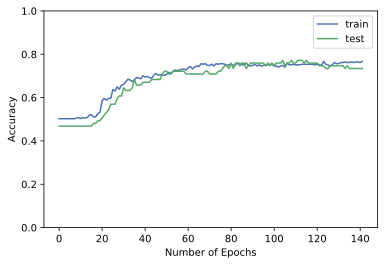

In [16]:
# get model's training history

plt.plot(model_history['accuracy'], label='train')
plt.plot(model_history['val_accuracy'], label='test')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.ylim([0, 1])
plt.legend()
plt.show()


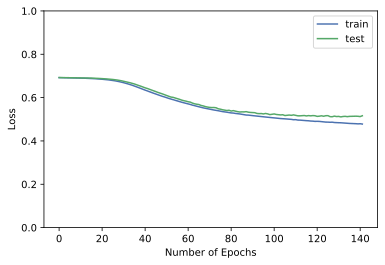

In [17]:
plt.plot(model_history['loss'], label='train')
plt.plot(model_history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.ylim([0, 1])
plt.legend()
plt.show()

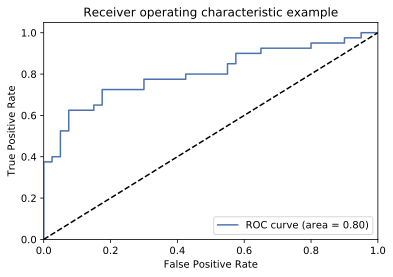

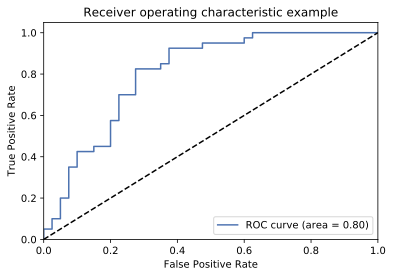

In [18]:
from sklearn.metrics import roc_curve, auc

Y_pred_proba = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

### Searching for specific datapoints for local evaluation

In [32]:
# get original vector
orig_vec = np.round(scaler.inverse_transform(X_test),6)
# generate all predictions for X
predictions = model.predict( X_test )
# extrace the label of the prediction of X[indx]
prediction_class = encoder.inverse_transform( predictions )

In [102]:

# 
local_data_dict = []
for indx in range(0, orig_vec.shape[0]):

    ground_truth = np.expand_dims(Y_test[indx], axis=0)
    ground_truth_class = encoder.inverse_transform( ground_truth )[0][0]
    
    prediction = prediction_class[indx][0]
    
    # check if data point is a true positive
    if( ( int(prediction) == int(ground_truth_class) ) & (int(prediction)==1) & (int(ground_truth_class)==1) ):
        pred_type = "TRUE POSITIVE"
    
    # check if data point is a true negative
    if( ( int(prediction) == int(ground_truth_class) ) & (int(prediction)==0) & (int(ground_truth_class)==0) ):
        pred_type = "TRUE NEGATIVE"

    # check if data point is a false negative
    if( ( int(prediction) != int(ground_truth_class) ) & (int(prediction)==0) & (int(ground_truth_class)==1) ):
        pred_type = "FALSE NEGATIVE"
    
    # check if data point is a false positve
    if( ( int(prediction) != int(ground_truth_class) ) & (int(prediction)==1) & (int(ground_truth_class)==0) ):
        pred_type = "FALSE POSITIVE"   
    
    local_data_dict.append( {'index' : indx,
                             'original_vector' : orig_vec[indx,:].tolist(),
                             'scaled_vector' : X_test[indx,:].tolist(),
                             'ground_truth' : ground_truth_class,
                             'predictions' : prediction,
                             'prediction_type' : pred_type})
    

In [103]:
# wrapping up information
true_positives = []
true_negatives = []
false_positives = []
false_negatives = []
for instance in local_data_dict:
    
    if( instance['prediction_type'] == 'TRUE POSITIVE'):
        true_positives.append(instance)

    if( instance['prediction_type'] == 'TRUE NEGATIVE' ):
        true_negatives.append(instance)
        
    if( instance['prediction_type'] == 'FALSE POSITIVE' ):
        false_positives.append(instance)
        
    if( instance['prediction_type'] == 'FALSE NEGATIVE' ):
        false_negatives.append(instance)

### Generating Explanations with LIME

In [104]:
MAX_FEAT = 6

# LIME has one explainer for all the models
explainer = lime_tabular.LimeTabularExplainer(X_train, feature_names= feature_names, 
                                                  class_names=["No Diabetes", "Diabetes"], verbose=False, mode='classification')


#### TRUE POSITIVES

In [ ]:
for instance in true_positives:

    print("INDEX = %d" %instance['index'])
    patients_feat = np.array(instance['scaled_vector'])
    
    # explain instance
    exp = explainer.explain_instance(patients_feat, model.predict_proba, num_features = 6 )
    
    # Show the predictions
    exp.show_in_notebook(show_table=True )
    explanation_plot = exp.as_pyplot_figure()
    explanation_plot.savefig(PATH+"explanations/diabetes/LIME/true_positives/IDX_" + str(instance['index'])+".png", dpi=300)
    print("\n--------------------------------------------------------------------------------------------\n")


#### TRUE NEGATIVES

In [ ]:
for instance in true_negatives:
    
    print("INDEX = %d" %instance['index'])
    patients_feat = np.array(instance['scaled_vector'])
    
    # explain instance
    exp = explainer.explain_instance(patients_feat, model.predict_proba, num_features = 6 )
    
    # Show the predictions
    exp.show_in_notebook(show_table=True )
    explanation_plot = exp.as_pyplot_figure()
    explanation_plot.savefig(PATH+"explanations/diabetes/LIME/true_negatives/IDX_" + str(instance['index'])+".png", dpi=300)
    
    print("\n--------------------------------------------------------------------------------------------\n")


#### FALSE POSITIVES

In [ ]:
for instance in false_positives:
    print("INDEX = %d" %instance['index'])
    patients_feat = np.array(instance['scaled_vector'])
    
    # explain instance
    exp = explainer.explain_instance(patients_feat, model.predict_proba, num_features = 6 )
    
    # Show the predictions
    exp.show_in_notebook(show_table=True )
    explanation_plot = exp.as_pyplot_figure()
    explanation_plot.savefig(PATH+"explanations/diabetes/LIME/false_positives/IDX_" + str(instance['index'])+".png", dpi=300)
    
    print("\n--------------------------------------------------------------------------------------------\n")


#### FALSE NEGATIVES

In [ ]:
for instance in false_negatives:

    print("INDEX = %d" %instance['index'])
    patients_feat = np.array(instance['scaled_vector'])
    
    # explain instance
    exp = explainer.explain_instance(patients_feat, model.predict_proba, num_features = 6 )
    
    # Show the predictions
    exp.show_in_notebook(show_table=True )
    explanation_plot = exp.as_pyplot_figure()
    explanation_plot.savefig(PATH+"explanations/diabetes/LIME/false_negatives/IDX_" + str(instance['index'])+".png", dpi=300)
    
    print("\n--------------------------------------------------------------------------------------------\n")


### Generating Explanations with SHAP

#### TRUE POSITIVES

#### TRUE NEGATIVES

#### FALSE POSITIVES

#### FALSE NEGATIVES

## Train a Model for the Unbalanced Dataset

In [ ]:
# apply one hot encoder to data
# standardize the input between 0 and 1
X_unb, Y_unb, encoder_unb, scaler = encode_data( data, class_var)

n_features = X_unb.shape[1]
n_classes = len(data[class_var].unique())

flag = False
if flag:
    # save training, test and validation data
    generate_save_training_data( dataset_path + "_unb", X_unb, Y_unb)
    
else:
    # load existing training data
    X_train_unb, Y_train_unb, X_test_unb, Y_test_unb, X_validation_unb, Y_validation_unb= load_training_data( dataset_path + "_unb" )
    